# PFD

The phase and frequency detector (PFD) compares the reference clock (CK_REF) with the feedback clock (CK_FB).

If the feedback clock is higher, the PFD should set CP_DOWN more high than CP_UP_N low.

If the feedback clock is lower, the PFD should set CP_DOWN less high than CP_UP_N low.


## Import the raw file from spice

In [16]:
import cicsim as cs 

dfs = cs.toDataFrames(cs.ngRawRead('../sim/SUN_PLL/output_tran/tran_SchGtVtKttTt.raw'))

# Only one run in the sim, so we select the first
df = dfs[0]

print(df.columns)

Index(['time', 'v(avdd)', 'v(avss)', 'v(ck)', 'v(ck_ref)', 'v(ibpsr_1u)',
       'v(pwrup_1v8)', 'i(vdd)', 'v(xdut.ck_fb)', 'v(xdut.cp_down)',
       'v(xdut.cp_up_n)', 'v(xdut.kick)', 'v(xdut.vdd_rosc)', 'v(xdut.vlpf)',
       'v(xdut.vlpfz)'],
      dtype='object')


## Plot signals

In [17]:
# Make a plot function so we can do multiple plots later
import matplotlib.pyplot as plt
def plot(tstart,clock_cycles=10):
    #- I know the ck_ref is 16 MHz, so specifying clock cycles is easier
    tstop = tstart + 1/16e6*clock_cycles

    f,axes = plt.subplots(4,1,sharex=True)
    axes[0].plot(df["time"],df["v(ck_ref)"])
    axes[0].set_ylabel("CK_REF")
    axes[1].plot(df["time"],df["v(xdut.ck_fb)"])
    axes[1].set_ylabel("CK_FB")
    axes[2].plot(df["time"],df["v(xdut.cp_up_n)"])
    axes[2].set_ylabel("CK_UP_N")
    axes[3].plot(df["time"],df["v(xdut.cp_down)"])
    axes[3].set_ylabel("CK_DOWN")
    plt.axis([tstart,tstop,0,2])
    plt.show()

### Early in settling

The startup circuit will force the CK_FB to a high frequency. So initially I expect that CK_UP_N is mostly off (the signal is active low), and CK_DOWN is mostly on. 

The plot below confirms the hypothesis

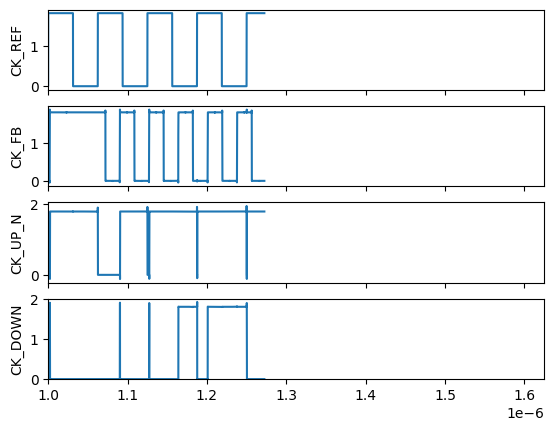

In [22]:
plot(1e-6)

### Later settling

As the PLL settles, the CK_REF might overshoot or undershoot. Plot below shows a case where CK_DOWN is mostly off, and CK_UP is mostly on.

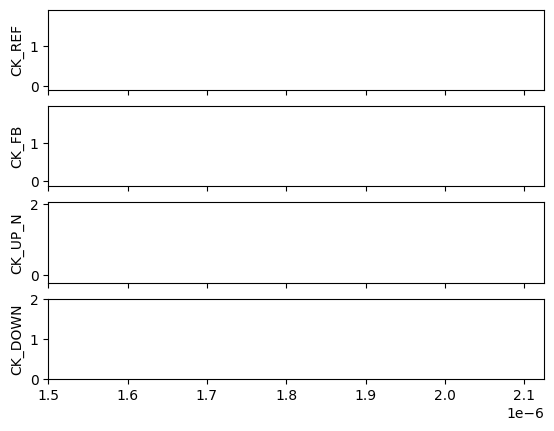

In [19]:
plot(1.5e-6)

### Final settling

As the PLL has settled both CK_UP_N and CK_DOWN should be mostly off, as confirmed by the plot. 

The phase of the feedback clock and the reference clock are aligned in time. 

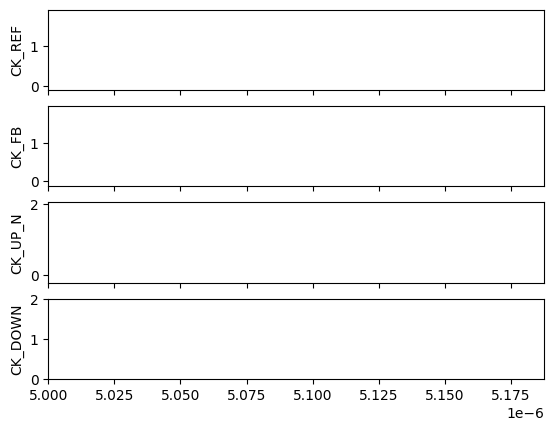

In [20]:
plot(5e-6,3)

# Frequency settling

I want to figure out the frequency, but first the data need to be massaged

In [21]:
import numpy as np
dft = df[["time","v(ck)"]]
dft.set_index("time",inplace=True)

#- There is probably a smarter way to do this, but 
# I've opted for brute force
#  1. Search through v(ck) and find crossing of vth and store delta time
#  2. Don't search for crossing when falling edge has been detected
#  3. Find falling edge
#  4. Go back to 1
prev = 0
searchFalling = False
vth = 0.8
ts = list()
time = list()
for v in dft["v(ck)"].iteritems():
    if(not searchFalling and v[1] > vth):
        t = v[0] - prev
        ts.append(t)
        time.append(v[0])
        prev = v[0]
        searchFalling = True

    if(searchFalling and v[1] < (vth-0.2)):
        searchFalling = False

#- Skip the first values, it's crap
ts.pop(0)
time.pop(0)

#- Convert to numpy arrays and find frequency
u = 1e-6
nts = np.array(ts)
ntime = np.array(time)
M = len(nts)
freq = 1/nts*u

#- Compute the average with a window
w = 200
freq_avg = np.convolve(freq, np.ones(w))/w

#- Plot
plt.plot(ntime/u,freq)
plt.plot(ntime[w:]/u,freq_avg[w:M])
plt.xlabel("Time [us]")
plt.ylabel("Frequency [MHz]")
plt.grid(True)
plt.tight_layout()
plt.show()

AttributeError: 'Series' object has no attribute 'iteritems'

The plot above confirms that the PLL settles.

The average is 512 MHz as expected, but we can see the standard deviation of the frequency is probably a bit high.

I've not checked whether the high standard deviation is due to ngspice numerical accuracy, or an actual problem with the design. For example, the phase detector.

In [ ]:
print("Average frequency = %.3f MHz" % (freq[M - int(M/8):].mean()))
print("Sigma frequency = %.3f MHz" %(freq[M - int(M/8):].std()))


Average frequency = 512.436 MHz
Sigma frequency = 23.916 MHz
